# Quantum Error Detection with Iceberg Codes

In this tutorial, we'll explore how to use the Iceberg quantum error detection library (iceberg_codes) alongside Qiskit to detect and mitigate errors in quantum circuits. We'll start by importing the required libraries:

In [ ]:
!pip install git+https://github.com/beittech/iceberg.git

In [72]:
from qiskit import transpile
from qiskit.circuit.library import quantum_volume
import iceberg_codes as ice
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np

## Constructing and Analyzing a Quantum Circuit

We begin by creating a Quantum Volume circuit—a standard benchmark circuit—and append its inverse to create an identity-like operation. We'll then transpile the circuit to a specific gate set and examine its depth and gate counts:



Depth: 52 | Ops: OrderedDict({'rz': 94, 'rx': 51, 'rzz': 24, 'measure': 4, 'barrier': 1})


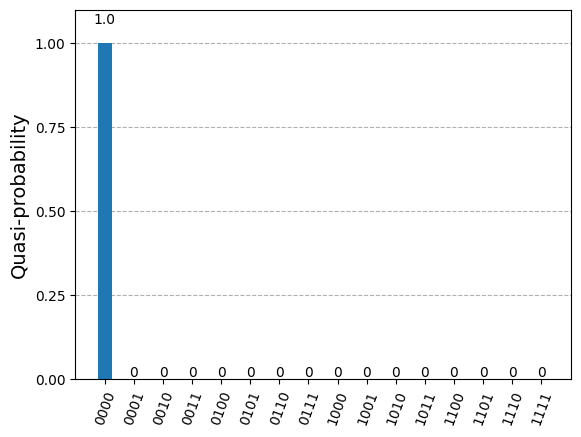

In [73]:
gate_set = ['x', 'z', 'rz', 'rx', 'rzz']
qc = quantum_volume(k := 4, 2, seed=42)
qc.append(qc.inverse(), qc.qubits)
qc_transpiled = transpile(qc.measure_all(inplace=False), basis_gates=gate_set)
print(f'Depth: {qc_transpiled.depth()} | Ops: {qc_transpiled.count_ops()}')

plot_histogram(sv := Statevector.from_instruction(qc).probabilities_dict())

## Compiling with Iceberg Error Detection

Now, let's compile our quantum circuit using the $[n,n-2, 2]]$ iceberg code using the `codeqraft/qed` api, adding periodic syndrome measurements to identify and post select on errors during execution. We'll again transpile the compiled circuit and inspect how its depth and gate count are affected by adding error detection:

In [79]:
qc_compiled = transpile(ice.compile(qc, syndrome_rate=16), basis_gates=gate_set)
print(f'Depth: {qc_compiled.depth()} | Ops: {qc_compiled.count_ops()}')

Depth: 1037 | Ops: OrderedDict({'rz': 958, 'rx': 414, 'rzz': 401, 'measure': 29, 'reset': 21, 'barrier': 20})


## Simulating the Circuit and Decoding Results

We'll simulate the compiled circuit using the AerSimulator from Qiskit, run multiple shots, and decode the results using Iceberg's decoding functionality. Decoding interprets measurement outcomes and discards unreliable results. Let's verify that the decoder produces the correct output under a noiseless simulation.

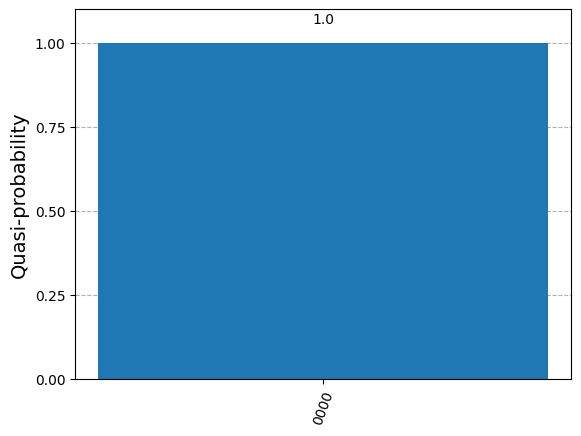

In [67]:
sim = AerSimulator()
counts = sim.run(qc_compiled, shots=2 ** 11)
decoded_result = ice.decode(counts, k=k)
plot_histogram(decoded_result.probabilities_dict())

## Adding Noise to Evaluate Performance

Real quantum hardware experiences errors. To evaluate how effectively the iceberg code detects and mitigates these errors, we'll introduce noise into our simulations. We'll simulate varying error rates, repeatedly execute the noisy circuit, and record two critical metrics: the survival rate (how many results pass decoding successfully) and the success probability (the probability of getting the correct, noiseless, result).

In [47]:
from tqdm import tqdm
import pandas as pd

shots = 2 ** 12
data = []
for p in tqdm(p := np.linspace(0.001, 0.005, 11)):
    sim = ice.circuit_noise_model(p=p)
    for _ in range(10):
        counts = sim.run(qc_compiled, shots=shots)
        try:
            decoded_result = ice.decode(counts, k=k)
            data.append(
                dict(
                    survival_rate=decoded_result.survival_rate,
                    success_probability=decoded_result.probabilities_dict()["0" * k],
                    error_rate=p * 1e3
                )
            )
        except ice.DecoderError:
            data.append(
                dict(
                    survival_rate=0,
                    success_probability=0,
                    error_rate=p * 1e3
                )
            )

df = pd.DataFrame(data)

100%|██████████| 11/11 [12:54<00:00, 70.44s/it]


## Analyzing Performance Metrics

Finally, we'll visualize how success probability and survival rate vary with increasing error rates.

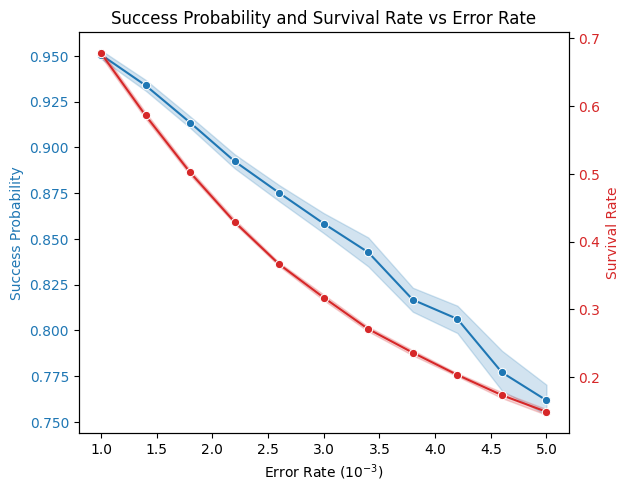

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color1 = 'tab:blue'
sns.lineplot(data=df, x='error_rate', y='success_probability', color=color1, ax=ax1, marker='o')
ax1.set_xlabel('Error Rate ($10^{-3}$)')
ax1.set_ylabel('Success Probability', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
sns.lineplot(data=df, x='error_rate', y='survival_rate', color=color2, ax=ax2, marker='o')
ax2.set_ylabel('Survival Rate', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('Success Probability and Survival Rate vs Error Rate')
plt.show()

## Resource Analysis and Limitations

The current compilation API demonstrated here is limited in scope, intended primarily for illustrative purposes. In practice, employing co-design methodologies and advanced heuristics can substantially reduce resource overhead, leading to more efficient implementations of quantum circuits. Below is a table summarizing compiled circuit resource counts from our related study on compiling Grover's algorithm with $[[n, n-2, 2]]$ codes

| Resource      | Compiled Value                                    | Overhead $(k \to \infty)$ |
|---------------|---------------------------------------------------|---------------------------|
| Qubits        | $2\lceil (k + 1)/2 \rceil + 4$                    | $1$                       |
| Measurements  | $2\lceil (k + 1)/2 \rceil + 3$                    | $1$                       |
| RZZ Count     | $10 + (-1)^k - 288d + 2k + 128dk$                 | $4$                       |
| U Count       | $\frac{1}{2}(51 + 5(-1)^k - 228d + 10k + 132dk)$  | $1.03125$                 |
| Circuit Depth | $18 + 2(-1)^k - 394d + 4k + 177dk$                | $2.765625$                |

Table: Compiled Circuit resource counts for $k$-qubit $d$ iteration grover search. In the limit where the number of logical qubits $k\to \infty$, and the number of Grover iterations is set to the optimal value $d=\lfloor (\pi/4 \times 2^{k/2}-1/2\rfloor$.